# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, â€¦ Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [RÃ¶stigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Web scraping
import requests
from bs4 import BeautifulSoup
import json
import branca.colormap as cm # for color steps


# Merging names. Installation: pip install fuzzywuzzy and pip install fuzzywuzzy[speedup]
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from IPython.core import display as ICD

import folium

[tsdsc330] - Long-term unemployment rate, by sex

Long-term unemployed (12 months and more) comprise persons aged at least 15, who are not living in collective households, who will be without work during the next two weeks, who would be available to start work within the next two weeks and who are seeking work (have actively sought employment at some time during the previous four weeks or are not seeking a job because they have already found a job to start later). The total active population (labour force) is the total number of the employed and unemployed population. The duration of unemployment is defined as the duration of a search for a job or as the period of time since the last job was held (if this period is shorter than the duration of the search for a job).

LEGEND
* **:** are non available data
* **b** break in the time serie
* **e** for estimated
* **u** low relialability
* **PC** for percentage
* **PPCH** for percentage point change t/(t-3)

where:      
_A percentage point or percent point (pp) is the unit for the arithmetic difference of two percentages. For example, moving up from 40% to 44% is a 4 percentage point increase, but is an actual 10 percent increase in what is being measured._



In [3]:
DATA_FOLDER = 'data/'
eurodf = pd.read_csv(DATA_FOLDER + 'tsdsc330' , sep='\t|,|[|]', engine='python')
eurodf.head(2)

indic_em     age    unit sex geo\time 1996  1997  1998   1999  2000  ...   \
0      LTU  Y15-74  PC_ACT   F       AT    :     :     :      :     :  ...    
1      LTU  Y15-74  PC_ACT   F       BE    :     :     :   6.0 b  4.7  ...    

   2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  
0  1.5 b  1.0   1.1   1.0   1.1   1.1   1.2   1.4   1.4   1.7  
1   4.3   3.6   3.6   4.1   3.6   3.2   3.7   3.8   3.9   3.8  

[2 rows x 26 columns]

In [4]:
eurodf.replace(to_replace=':', value='nan',inplace=True, regex=True)
eurodf.head(2)

indic_em     age    unit sex geo\time 1996  1997  1998   1999  2000  ...   \
0      LTU  Y15-74  PC_ACT   F       AT  nan   nan   nan    nan   nan  ...    
1      LTU  Y15-74  PC_ACT   F       BE  nan   nan   nan   6.0 b  4.7  ...    

   2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  
0  1.5 b  1.0   1.1   1.0   1.1   1.1   1.2   1.4   1.4   1.7  
1   4.3   3.6   3.6   4.1   3.6   3.2   3.7   3.8   3.9   3.8  

[2 rows x 26 columns]

Since the columns 'indic_em', 'age', 'unit' list only one value, they don't provide us any information and to be as clear as possible we drop them

In [5]:
eurodf.drop(['indic_em','age','unit'],inplace=True, axis=1)
eurodf.columns.values[1] = 'country code'

In [6]:
codes = pd.DataFrame([eurodf[eurodf['sex']=='T']['country code'],
                     eurodf[eurodf['sex']=='F']['country code'],
                     eurodf[eurodf['sex']=='M']['country code']])
codes

0    1    2    3    4    5    6    7     8     9   ...   101  \
country code  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN ...    NL   
country code   AT   BE   BG   CH   CY   CZ   DE   DK  EA18  EA19 ...   NaN   
country code  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN ...   NaN   

              102  103  104  105  106  107  108  109  110  
country code   NO   PL   PT   RO   SE   SI   SK   TR   UK  
country code  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
country code  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[3 rows x 111 columns]

We are interested in noticing how many data are considered of low reliability, and so carachterized by a 'u'. 

In [7]:
eurodf.replace(['b','e'],['',''],regex=True,inplace=True)
count = 0
for col in eurodf.columns[2:]:
    for cell in eurodf[col]:
        if 'u' in cell:
            count=count+1
print(count)
eurodf.head()

44


sex country code 1996  1997  1998  1999  2000   2001   2002  2003  ...   \
0   F           AT  nan   nan   nan   nan   nan    nan    1.1   1.0  ...    
1   F           BE  nan   nan   nan   6.0   4.7    3.5    4.3   4.2  ...    
2   F           BG  nan   nan   nan   nan   9.4   11.9   11.4   8.6  ...    
3   F           CH  nan   nan   nan   nan   nan    nan    nan   nan  ...    
4   F           CY  nan   nan   nan   nan   nan    nan    nan   nan  ...    

   2007   2008   2009  2010  2011  2012  2013  2014  2015  2016  
0   1.5    1.0    1.1   1.0   1.1   1.1   1.2   1.4   1.4   1.7  
1   4.3    3.6    3.6   4.1   3.6   3.2   3.7   3.8   3.9   3.8  
2   4.5    3.1    3.1   4.4   5.5   5.8   6.6   6.0   5.0   4.1  
3   nan    nan    nan   1.9   1.7   1.6   1.7   1.9   1.9   1.9  
4  0.7 u  0.5 u  0.6 u  1.3   1.5   3.1   5.6   7.0   6.2   5.1  

[5 rows x 23 columns]

Now we can get rid of all the non-numeric flag that accompany each number:

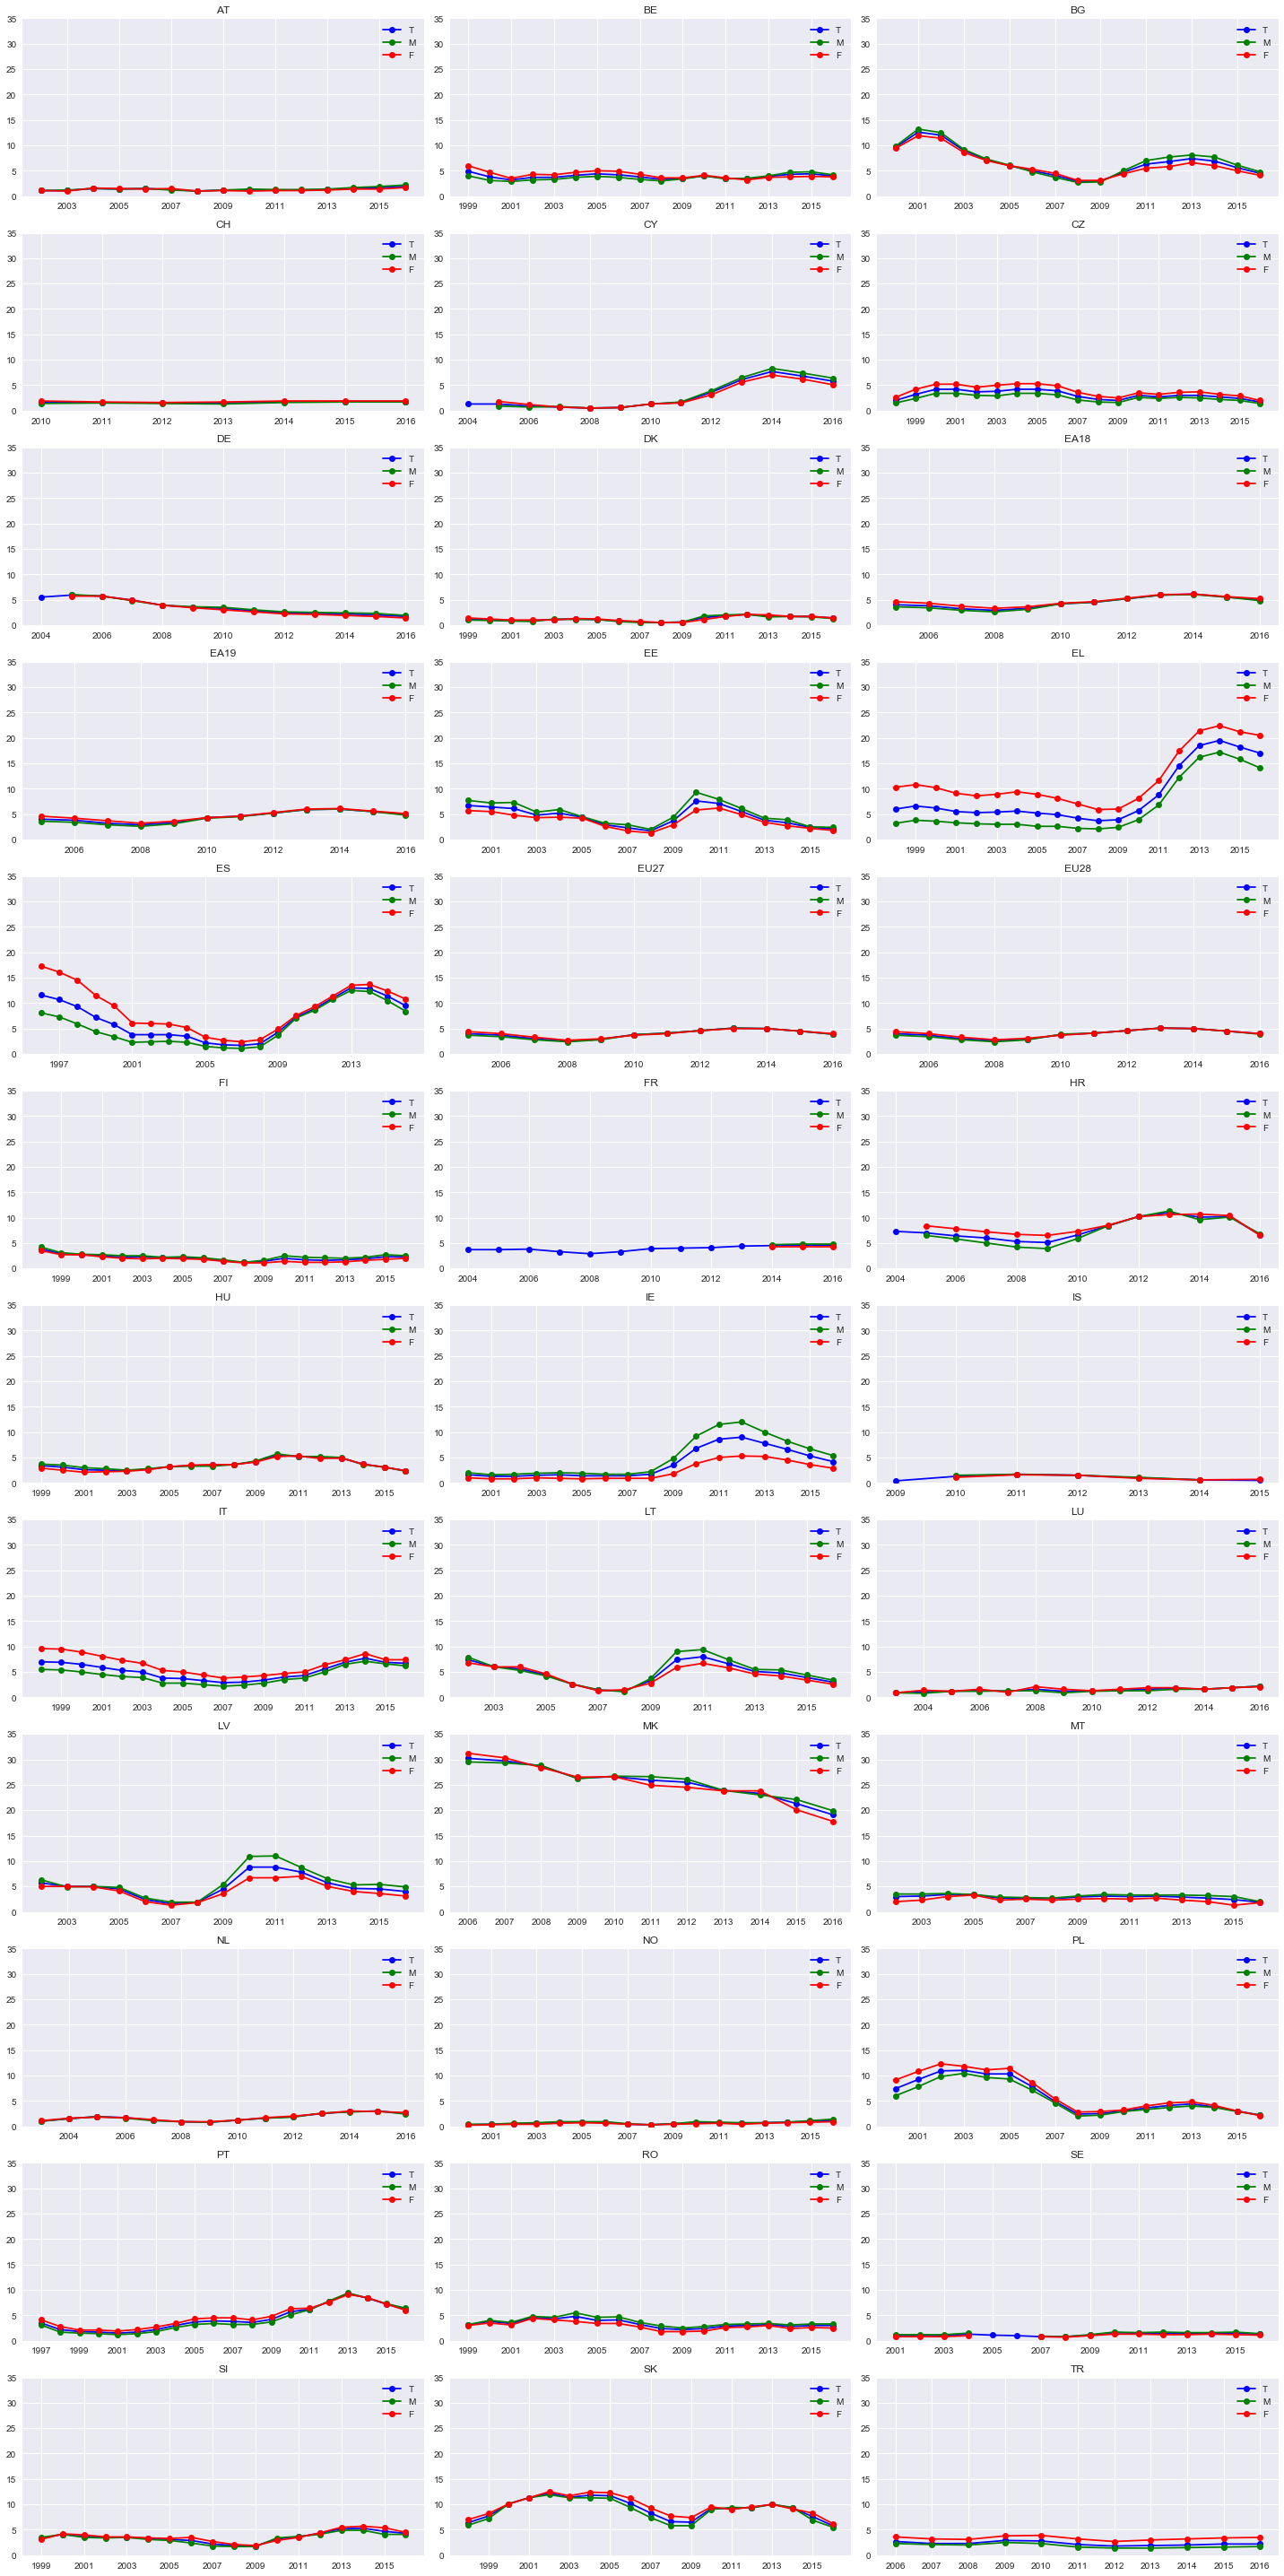

In [8]:
eurodf.replace('u','',regex=True,inplace=True)
eurodf[eurodf.columns[2:]]=eurodf[eurodf.columns[2:]].astype(float)

fig, axes =  plt.subplots(12,3, figsize=[20,40])
totaldf = eurodf[eurodf["sex"]=='T'].reset_index(drop=True)
maledf = eurodf[eurodf["sex"]=='M'].reset_index(drop=True)
femaledf = eurodf[eurodf["sex"]=='F'].reset_index(drop=True)

for i,ax in enumerate(axes.reshape(-1)):
    '''sns.tsplot(totaldf.loc[i][2:], ax = ax, color="indianred", time=totaldf.columns[2:],label='T').set_title(totaldf.loc[i][1])
    sns.tsplot(maledf.loc[i][2:], ax = ax, color="#3498db", time=maledf.columns[2:],label='M')
    sns.tsplot(femaledf.loc[i][2:], ax = ax, color="#2ecc71", time=femaledf.columns[2:],label='F')'''
    
    ax.plot_date(totaldf.columns[2:], totaldf.loc[i][2:], color="blue", label="T", linestyle="-")
    ax.plot_date(maledf.columns[2:], maledf.loc[i][2:], color="green", label="M", linestyle="-")
    ax.plot_date(femaledf.columns[2:], femaledf.loc[i][2:], color="red", label="F", linestyle="-")
    ax.set_title(totaldf.loc[i][1])
    ax.set_ylim(0,35)
    #ax.set(xticks=[1996,2000,2004,2008,2012,2016])
    ax.legend()

fig.tight_layout()
plt.show()

It could be interesting to see which nations have a higher difference in the unemplyment rate for male and women:

In [37]:
diffdf = maledf[maledf.columns[2:]].subtract(femaledf[femaledf.columns[2:]],axis='columns')

In [50]:

diffdf=diffdf.transpose()
diffdf.columns=maledf['country code']

In [52]:
diffdf.head(10)

country code   AT   BE   BG  CH   CY   CZ   DE   DK  EA18  EA19 ...    NL  \
1996          NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   NaN   NaN ...   NaN   
1997          NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   NaN   NaN ...   NaN   
1998          NaN  NaN  NaN NaN  NaN -1.1  NaN  NaN   NaN   NaN ...   NaN   
1999          NaN -2.0  NaN NaN  NaN -1.8  NaN -0.4   NaN   NaN ...   NaN   
2000          NaN -1.6  0.4 NaN  NaN -1.8  NaN -0.3   NaN   NaN ...   NaN   
2001          NaN -0.6  1.3 NaN  NaN -1.8  NaN -0.2   NaN   NaN ...   NaN   
2002          0.0 -1.1  1.1 NaN  NaN -1.6  NaN -0.3   NaN   NaN ...   NaN   
2003          0.2 -0.9  0.6 NaN  NaN -2.1  NaN  0.2   NaN   NaN ...  -0.1   
2004         -0.1 -1.0  0.3 NaN  NaN -1.9  NaN -0.2   NaN   NaN ...  -0.1   
2005         -0.1 -1.1  0.1 NaN -0.9 -1.9  0.3 -0.1  -1.0  -1.0 ...   0.1   

country code   NO   PL   PT   RO   SE   SI   SK  TR   UK  
1996          NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
1997          NaN  NaN -1.0  NaN  NaN  NaN  NaN NaN  NaN  
1998          NaN  NaN -1.1  NaN  NaN  NaN -1.1 NaN  NaN  
1999          NaN  NaN -0.6  0.2  NaN  0.4 -1.0 NaN  NaN  
2000          0.2 -3.1 -0.7  0.5  NaN -0.1  0.0 NaN  1.1  
2001          0.1 -3.0 -0.7  0.5  0.4 -0.5  0.0 NaN  0.9  
2002          0.2 -2.5 -0.8  0.4  0.4 -0.2 -0.6 NaN  0.7  
2003          0.3 -1.4 -0.9  0.5  0.4 -0.1 -0.4 NaN  0.7  
2004          0.3 -1.5 -0.8  1.7  0.5 -0.3 -1.1 NaN  0.6  
2005          0.2 -2.1 -1.1  1.2  NaN -0.4 -1.1 NaN  0.6  

[10 rows x 37 columns]

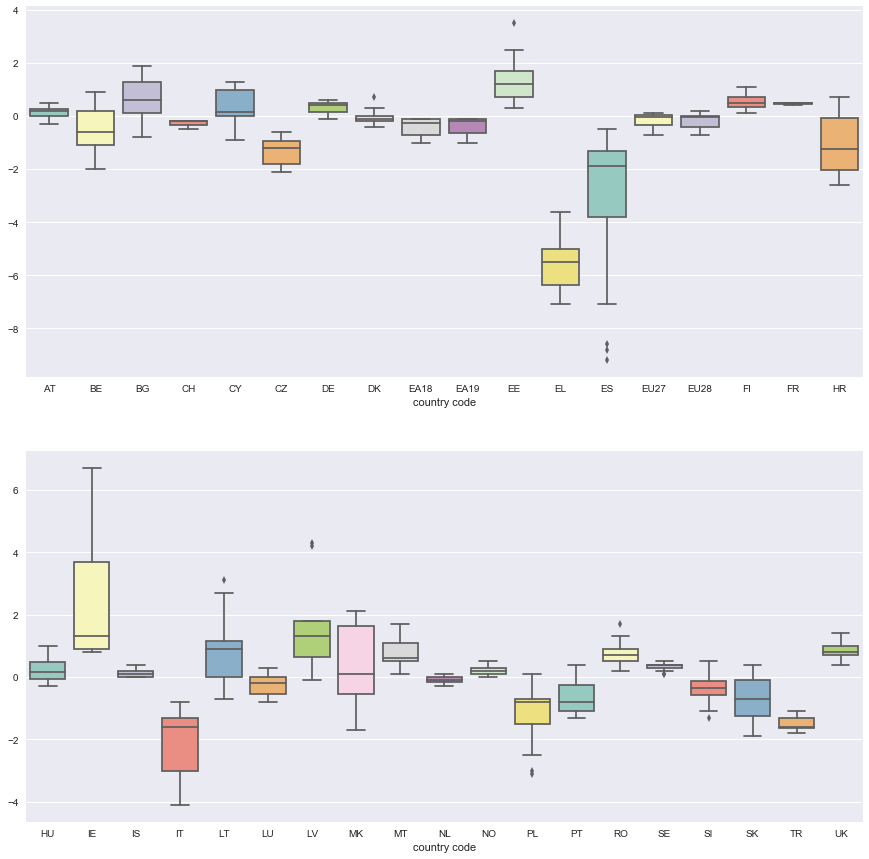

In [57]:
fig2, ax2 =  plt.subplots(2, figsize=(15,15))
sns.boxplot(data=diffdf[diffdf.columns[:18]], palette="Set3", ax = ax2[0])
sns.boxplot(data=diffdf[diffdf.columns[18:]], palette="Set3", ax = ax2[1])

In [67]:
chdf = pd.read_excel(DATA_FOLDER + 'ch.xlsx',header=[0,1])

chdf.head(10)

Cantone        Nazionalità     mese           Novembre 2016  \
        Unnamed: 0_level_1 Metriche Tasso di disoccupazione   
Zurigo           stranieri      NaN                     6.1   
Zurigo            svizzeri      NaN                     2.8   
Berna            stranieri      NaN                     6.9   
Berna             svizzeri      NaN                     2.0   
Lucerna          stranieri      NaN                     4.6   
Lucerna           svizzeri      NaN                     1.4   
Uri              stranieri      NaN                     4.5   
Uri               svizzeri      NaN                     0.6   
Svitto           stranieri      NaN                     3.9   
Svitto            svizzeri      NaN                     1.2   

Cantone                                                    \
        Coefficiente di variazione Disoccupati registrati   
Zurigo                           A                  13988   
Zurigo                           A                  16663   
Berna                            A                   6083   
Berna                            A                   9670   
Lucerna                          B                   1861   
Lucerna                          A                   2568   
Uri                              D                    114   
Uri                              C                    104   
Svitto                           C                    709   
Svitto                           B                    848   

Cantone                                                      Dicembre 2016  \
        Persone in cerca d'impiego non disoccupate Tasso di disoccupazione   
Zurigo                                        3336                     6.4   
Zurigo                                        3733                     2.9   
Berna                                         2237                     7.3   
Berna                                         2971                     2.1   
Lucerna                                       1457                     5.1   
Lucerna                                       1663                     1.5   
Uri                                             85                     5.3   
Uri                                             73                     0.6   
Svitto                                         453                     4.4   
Svitto                                         365                     1.3   

Cantone                                                    \
        Coefficiente di variazione Disoccupati registrati   
Zurigo                           A                  14614   
Zurigo                           A                  16956   
Berna                            A                   6488   
Berna                            A                  10148   
Lucerna                          B                   2100   
Lucerna                          A                   2783   
Uri                              D                    135   
Uri                              C                    107   
Svitto                           C                    798   
Svitto                           B                    885   

Cantone                                             \
        Persone in cerca d'impiego non disoccupate   
Zurigo                                        3343   
Zurigo                                        3678   
Berna                                         2016   
Berna                                         2985   
Lucerna                                       1367   
Lucerna                                       1621   
Uri                                             72   
Uri                                             93   
Svitto                                         425   
Svitto                                         404   

Cantone                    ...                             Settembre 2017  \
                           ...                     Disoccupati registrati   
Zurigo                     ...       